# Steerable Pyramid

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

import pyrtools as pt
import plenoptic as po
%matplotlib inline
from plenoptic.simulate import Steerable_Pyramid_Freq
from plenoptic.tools.data import to_numpy
dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
#DATA_PATH = os.path.abspath('../data')
DATA_PATH = os.path.abspath(os.getcwd() + '/proj/lcv-software/plenoptic/data/')
%load_ext autoreload

%autoreload 2


This tutorial walks through the basic features of the torch implementation of the Steerable Pyramid. We use the steerable pyramid construction in the frequency domain (such that it provides perfect reconstruction and any number of orientation bands). For more details on steerable pyramids and how they are built, see the pyrtools tutorial at: https://pyrtools.readthedocs.io/en/latest/. 
Here we will specifically focus on the specifics of the torch version and how it may be used in concert with other differentiable torch models. 
First, let's instantiate a pyramid and visualize the impulse response. This is done by creating an impulse in each band of the pyramid and then using the recon_pyr function to reconstruct the image based on each band separately. 

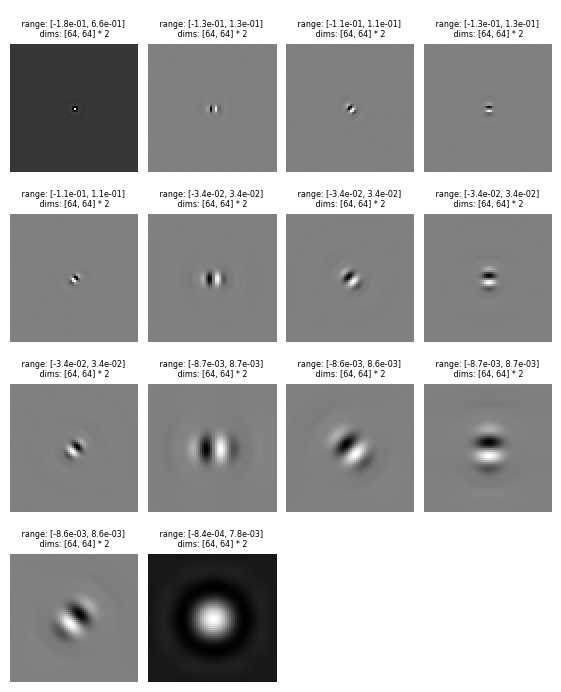

In [2]:
order = 3
imsize = 64
pyr = Steerable_Pyramid_Freq(height=3,image_shape=[imsize,imsize],order=order,is_complex = False,twidth=1, downsample=True)
pyr.to(device)
empty_image = torch.zeros((1,1,imsize,imsize),dtype=dtype).to(device)
pyr_coeffs = pyr.forward(empty_image)

for k,v in pyr.pyr_size.items():
    mid = (v[0]//2, v[1]//2)
    pyr_coeffs[k][0,0,mid[0],mid[1]]=1

reconList = []
for k in pyr_coeffs.keys():
    if isinstance(k, tuple):
        reconList.append(pyr.recon_pyr(pyr_coeffs, k[0], k[1]))
    else:
        reconList.append(pyr.recon_pyr(pyr_coeffs, k))
        
po.imshow(reconList, col_wrap=order+1, vrange='indep1', zoom=2);

We can see that this pyramid is representing a 4 scale 4 orientation decomposition. Now let's see what the steerable pyramid representation for images look like. <br>  
Unlike the pyrtools version, because we are using torch we can perform batch computations with the steerable pyramid implementation. Therefore, the input can be a tensor of size (B x C x H x W). In general C = 1, because the pyramid is meant to operate on gray-scale images, but in the current implementation C > 1 will cause the pyramid to run independently on each channel. The output of the real pyramid will be (B x C x H x W): 

torch.Size([2, 1, 256, 256])


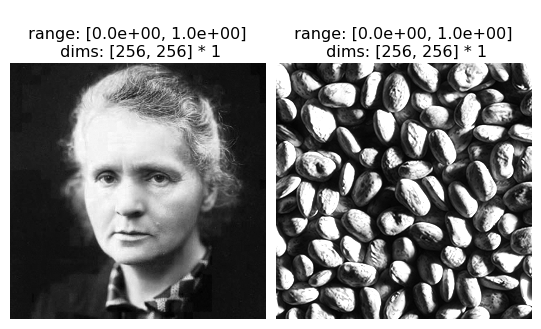

In [14]:
im1 = torch.tensor(plt.imread(os.path.join(DATA_PATH, f'256/curie.pgm')).astype(float), dtype=dtype).to(device) / 255
im2 = torch.tensor(plt.imread(os.path.join(DATA_PATH, f'256/nuts.pgm')).astype(float), dtype=dtype).to(device) / 255
im_batch = torch.stack((im1, im2),0).unsqueeze(1)
print(im_batch.shape)
po.imshow(im_batch)
order = 3
dim_im = 256
pyr = Steerable_Pyramid_Freq(height=4,image_shape=[dim_im,dim_im],order=order,is_complex = True,twidth=1, downsample=False)
pyr.to(device)
pyr_coeffs = pyr(im_batch)

from collections import OrderedDict
def upsample_pyr(pyr_coeffs):
    upsampl_pyr_dict = OrderedDict()
    for k,v in pyr_coeffs.items():
        band = v
        dim = band.shape[-1]
        upsamp_factor = int(dim_im/dim)
        n_blur = int(np.log2(upsamp_factor))
        print(dim, dim_im, upsamp_factor, n_blur)
        if upsamp_factor > 1:
            for i in range(n_blur):
                band = po.upsample_blur(band, filtname ='binom5', step=(2, 2))
        upsampl_pyr_dict[k] = band

    return upsampl_pyr_dict

In [15]:
im_multi = torch.stack((im1, im2), 0).unsqueeze(0)
print(im_multi.shape)
pyr_coeffs_multi = pyr(im_multi)
print(pyr_coeffs_multi[(0,0)].shape)
pyr_tens, pyr_info = pyr.convert_pyr_to_tensor(pyr_coeffs_multi, split_complex=True)
print(pyr_info)
pyr_coeffs_multi_2 = pyr.convert_tensor_to_pyr(pyr_tens, pyr_info)
for k in pyr_coeffs_multi.keys():
	print(k)
	print(torch.all(torch.eq(pyr_coeffs_multi[k], pyr_coeffs_multi_2[k])))


torch.Size([1, 2, 256, 256])
torch.Size([1, 2, 256, 256])
[2, True, ['residual_highpass', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), 'residual_lowpass']]
residual_highpass
tensor(True)
(0, 0)
tensor(True)
(0, 1)
tensor(True)
(0, 2)
tensor(True)
(0, 3)
tensor(True)
(1, 0)
tensor(True)
(1, 1)
tensor(True)
(1, 2)
tensor(True)
(1, 3)
tensor(True)
(2, 0)
tensor(True)
(2, 1)
tensor(True)
(2, 2)
tensor(True)
(2, 3)
tensor(True)
(3, 0)
tensor(True)
(3, 1)
tensor(True)
(3, 2)
tensor(True)
(3, 3)
tensor(True)
residual_lowpass
tensor(True)


In the default, the output of the pyramid is stored as a dictionary whose keys are either a string for the 'residual_lowpass' and 'residual_highpass' bands or a tuple of (scale_index, orientation_index). In order to visualize, the pyr_coeffs for each image and channel, in the batch, we can use the following:

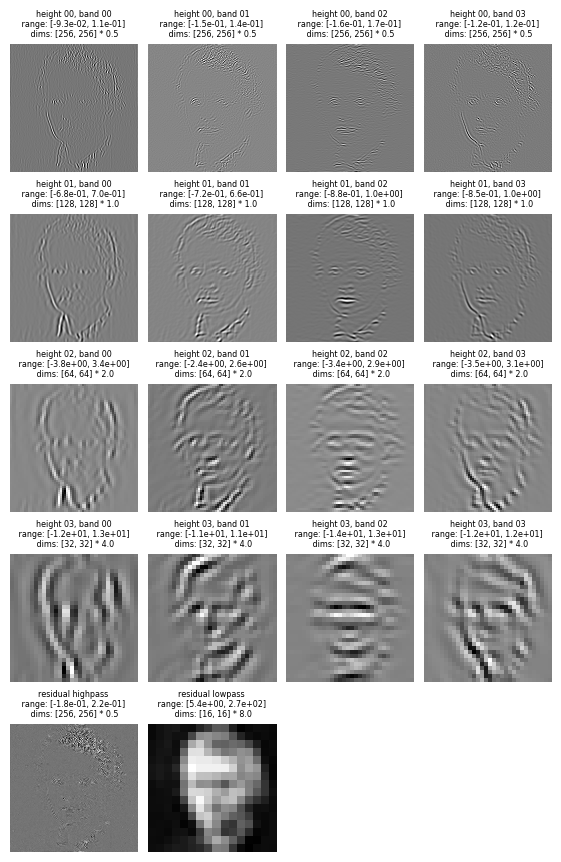

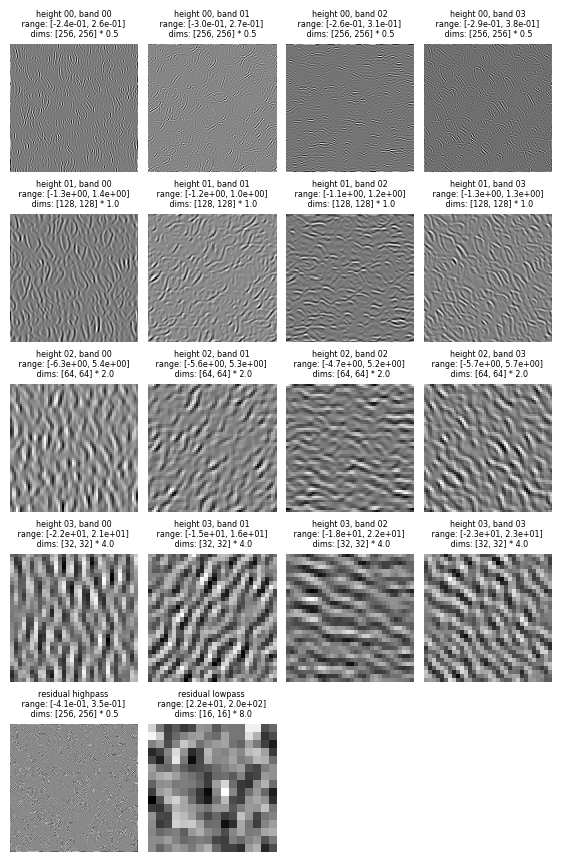

In [4]:
po.pyrshow(pyr_coeffs, zoom=0.5, batch_idx=0);
po.pyrshow(pyr_coeffs, zoom=0.5, batch_idx=1);

A feature of the pyramid implementation is however, we don't need to output all scales of the pyramid during the forward if they are not necessary. This functionality is especially useful for coarse-to-fine optimization procedures. We can easily change the output of pyramid by passing a `scales` argument to the forward pass as follows:

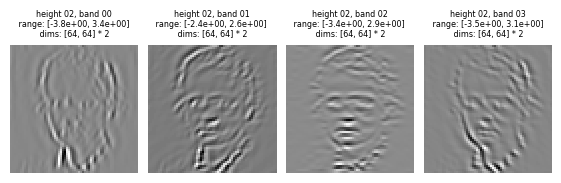

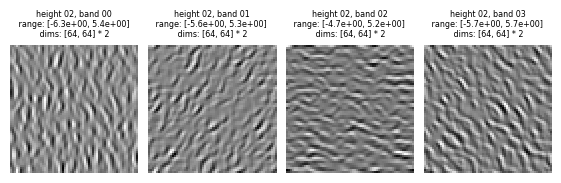

In [5]:
#get the 3rd scale
pyr_coeffs_scale0 = pyr(im_batch, scales=[2])
po.pyrshow(pyr_coeffs_scale0, zoom=2, batch_idx=0);
po.pyrshow(pyr_coeffs_scale0, zoom=2, batch_idx=1);

The above pyramid was the real pyramid but in many applications we might want the full complex pyramid output. This can be set using the 'is_complex' argument. When this is true, the output of the pyramid will be a dictionary of complex tensors rather than real tensors. 

In [6]:
order = 3
height = 3

pyr_complex = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=True, tight_frame=True)
pyr_complex.to(device)
pyr_coeffs_complex = pyr_complex(im_batch)

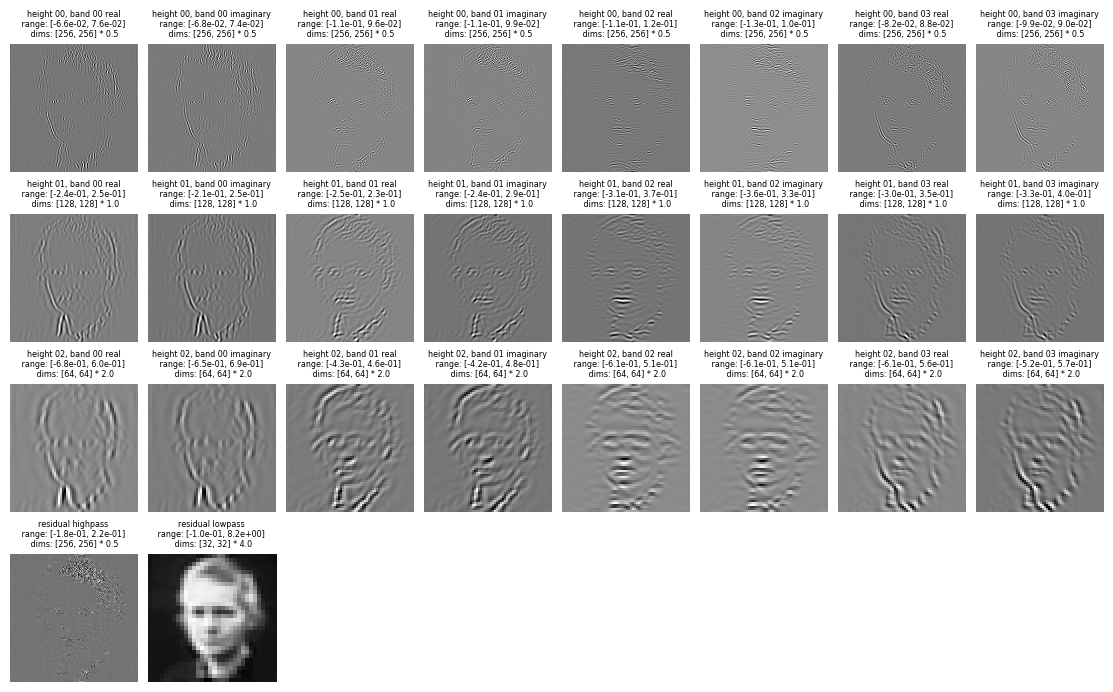

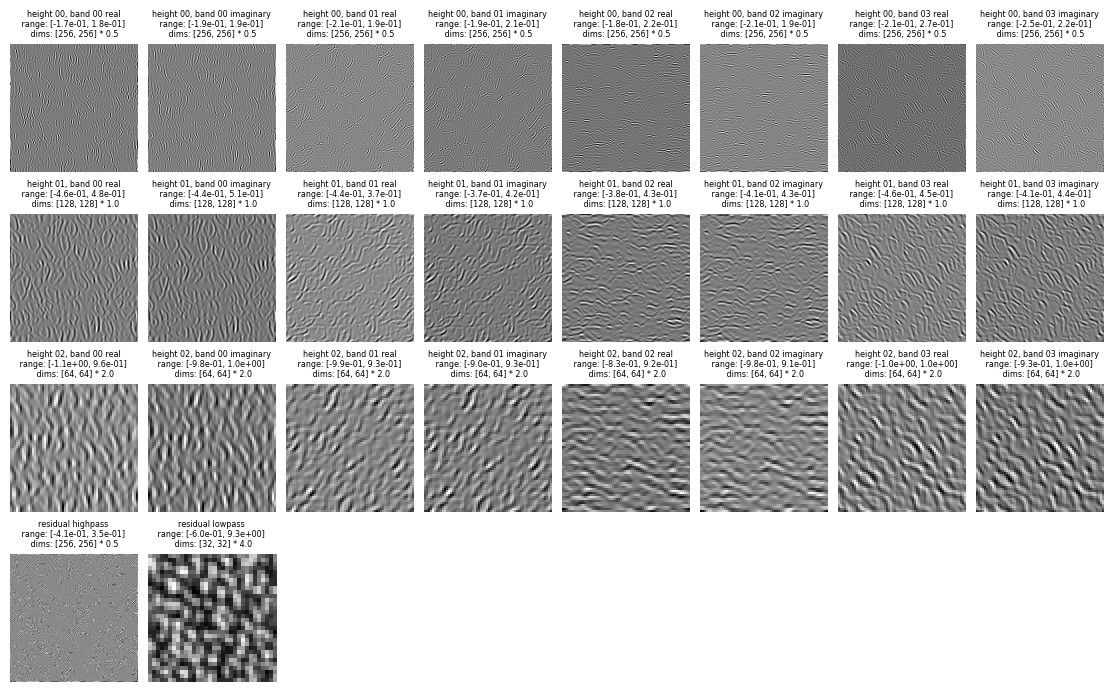

In [7]:
po.pyrshow(pyr_coeffs_complex, zoom=0.5, batch_idx=0);
po.pyrshow(pyr_coeffs_complex, zoom=0.5, batch_idx=1);

Now that we have seen the basics of using the pyramid, we will address a few important properties of the torch pyramid that may impact your use-case. 
1. The pyramid as it stands cannot process images with odd-sizes (i.e. 255x255). The reasons for this are being addressed but in the current version, note that if you have odd-sized images you will be forced to convert them to an even size before running through the pyramid. 
2. An important property of the steerable pyramid is that it should respect the generalized parseval theorem (i.e. the energy of the pyramid coefficients should equal the energy of the original image). The matlabpyrtools and pyrtools versions of the SteerablePyramid DO NOT respect this, so in our version, we have provided a fix that normalizes the FFTs such that energy is preserved. This is set by default using the `tight_frame=True` when instantiating the pyramid; however, if you require matching the outputs to the matlabPyrTools or PyrTools versions, please note that you will need to set this argument to False.  

Now, until now we have just seen how to use the Steerable Pyramid as a stand-alone fixed feature extractor, but what if we wanted to use it in a larger modeol, as a front-end for a deep CNN or other model? Most standard model architectures only accept channels with fixed shape, but each scale of the pyramid coefficients has a different shape (because each scale is downsampled by a factor of 2). In order to obtain an output amenable to downstream processing by standard torch nn modules, we have created an argument to the pyramid(`downsample=False`) that does not downsample the frequency masks at each scale and thus maintains output feature maps that all have a fixed size. Once you have done this, you can then convert the dictionary into a tensor of size BxCxHxW so that it can easily be passed to a downstream `nn.Module`. The details of how to do this are provided in the the `convert_pyr_to_tensor` function within the Steerable_Pyramid_Freq class. Let's try this and look at the first image both in the downsampled and not downsampled versions:

In [8]:
height = 3
order = 3
pyr_fixed  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = True,twidth=1, downsample=False, tight_frame=True)
pyr_fixed.to(device)
pyr_coeffs_fixed = pyr_fixed.convert_pyr_to_tensor(pyr_fixed(im_batch))
pyr_coeffs_split = pyr_fixed.convert_pyr_to_tensor(pyr_fixed(im_batch), split_complex=True)
print(pyr_coeffs_split.shape)
print(pyr_coeffs_fixed.shape)
#pyr_coeffs_viewed = torch.view_as_real(pyr_coeffs_fixed)
#pyr_coeffs_viewed.shape

torch.Size([2, 26, 256, 256])
torch.Size([2, 14, 256, 256])


We can see that in this complex pyramid with 4 scales and 3 orientations there will be 26 channels: 4 scales x 3 orientations x 2 (for real and imaginary featuremaps) + 2 (for the residual bands). NOTE: you can change what scales/residuals get included in this output tensor again using the `scales` argument to the forward method. 

In order to display the coefficients, we need to convert the tensor coefficients back to a dictionary. We can do this either by directly accessing the dictionary version (through the `pyr_coeffs` attribute in the pyramid object) or by using the internal `convert_tensor_to_pyr` function. We can check that these are equal.

In [9]:
# it looks like the residual highpass gets cast to complex by convert_tensor_to_pyr
pyr_coeffs_fixed_1 = pyr_fixed(im_batch)
pyr_coeffs_fixed_2 = pyr_fixed.convert_tensor_to_pyr(pyr_coeffs_fixed)
for k in pyr_coeffs_fixed_1.keys():
    print(torch.allclose(pyr_coeffs_fixed_2[k], pyr_coeffs_fixed_1[k]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True


We can now plot the coefficients for the not downsampled version (`pyr_coeffs_complex`) and the downsampled version `pyr_fixed_dict2` and see how they compare visually. 

tensor(425.6558) tensor(425.6558)


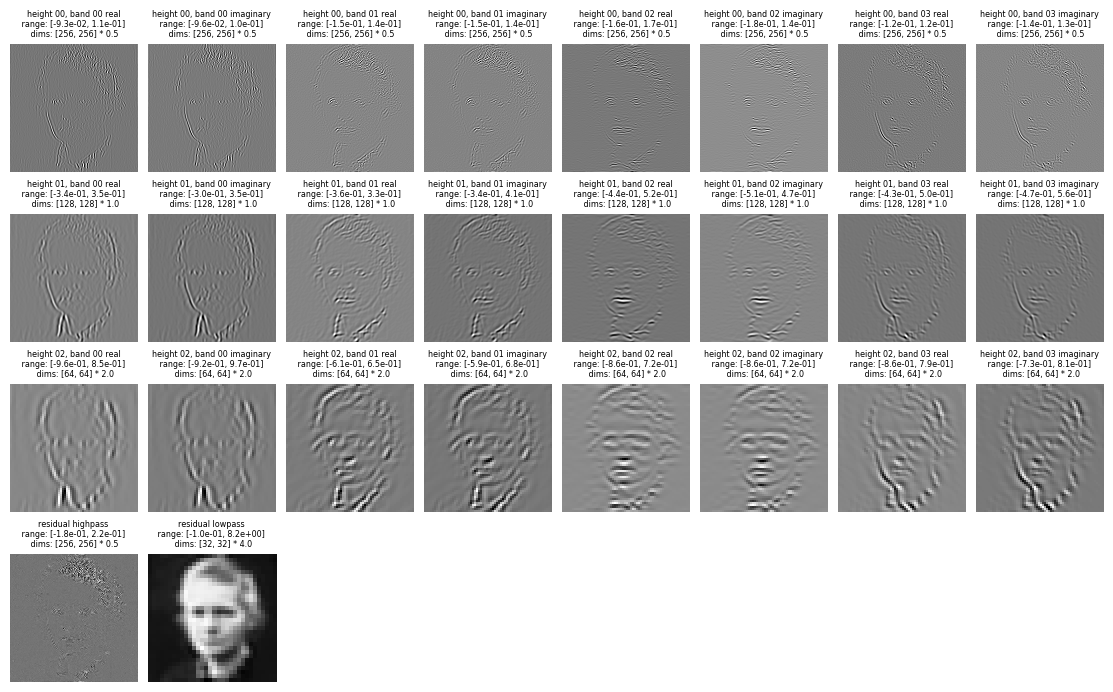

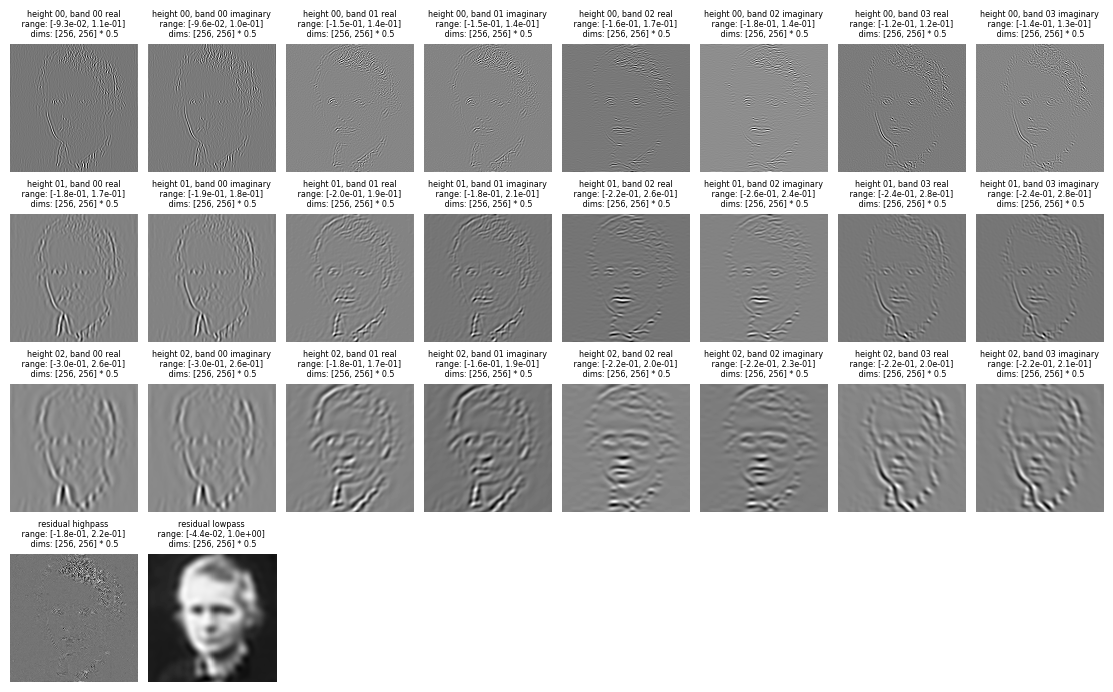

In [10]:
po.pyrshow(pyr_coeffs_complex, zoom=0.5);
po.pyrshow(pyr_coeffs_fixed_1, zoom=0.5);
#pyr_coeffs_upsamp = upsample_pyr(pyr_coeffs_complex)

#po.pyrshow(pyr_coeffs_upsamp, zoom=0.5);
print(pyr_coeffs_fixed_1[(1,1)].abs().square().sum(), pyr_coeffs_complex[(1,1)].abs().square().sum())

We can see that the not downsampled version maintains the same features as the original pyramid, but with fixed feature maps that have spatial dimensions equal to the original image (256x256). However, the pixel magnitudes in the bands are different due to the fact that we are not downsampling in the frequency domain anymore. This can equivalently be thought of as the inverse operation of blurring and downsampling. Therefore the upsampled versions of each scale are not simply zero interpolated versions of the downsampled versions and thus the pixel values are non-trivially changed.
However, the energy in each band should be preserved between the two pyramids and we can check this by computing the energy in each band for the two pyramids and checking if they are the same. 

In [16]:
pyr_not_downsample  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = False,twidth=1, downsample=False, tight_frame=False)
pyr_not_downsample.to(device)

pyr_downsample  = Steerable_Pyramid_Freq(height=height,image_shape=[256,256],order=order,is_complex = False,twidth=1, downsample=True, tight_frame=False)
pyr_coeffs_downsample = pyr_downsample(im_batch)
pyr_coeffs_not_downsample = pyr_not_downsample(im_batch)
for i in range(len(pyr_coeffs_downsample.keys())):
    k = list(pyr_coeffs_downsample.keys())[i]
    v1 = to_numpy(pyr_coeffs_downsample[k])
    v2 = to_numpy(pyr_coeffs_not_downsample[k])
    v1 = v1.squeeze()
    v2 = v2.squeeze()
    #check if energies match in each band between downsampled and fixed size pyramid responses
    print(np.allclose(np.sum(np.abs(v1)**2), np.sum(np.abs(v2)**2), rtol=1e-4, atol=1e-4))

def check_parseval(im ,coeff, rtol=1e-4, atol=0):
    '''
    function that checks if the pyramid is parseval, i.e. energy of coeffs is
    the same as the energy in the original image.
    Args:
    input image: image stimulus as torch.Tensor
    coeff: dictionary of torch tensors corresponding to each band
    '''
    total_band_energy = 0
    im_energy = im.abs().square().sum().numpy()
    for k,v in coeff.items():
        band = coeff[k]
        print(band.abs().square().sum().numpy())
        total_band_energy += band.abs().square().sum().numpy()

    np.testing.assert_allclose(total_band_energy, im_energy, rtol=rtol, atol=atol)

#check_parseval(im_batch[0,...], pyr_downsample(im_batch[0,...].unsqueeze(0)))



    



NameError: name 'height' is not defined

In [24]:
pyr_one_orient = Steerable_Pyramid_Freq(height=3,image_shape=[256,256],order=1,is_complex = False,twidth=1, downsample=True, tight_frame=False)
im_impulse = torch.zeros((1,1,256,256))
im_impulse[0,0,128,128] = 1
coeff = pyr_one_orient(im_batch)
steered, steer_weights = pyr_one_orient.steer_coeffs(coeff, [np.pi/4, -np.pi/4])

#po.pyrshow(steer_weights);
#steered_coeffs